
## Prithvi Raj Kola Aashavardhan

# Learning Hyperparameter tuning with keras on coursera and experimenting with Fine Tuning

<img src="Certificate.jpg" width=600 align="center">

# Building a Model and finding the best parameters with Keras_tuner

In [3]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras.layers import Conv2D, Flatten,Dense,Activation,Dropout,MaxPooling2D

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# TO DO: import reshape and scale the data
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape(len(x_train),28,28,1)


x_test = x_test.astype('float32') / 255.0
x_test = x_test.reshape(len(x_test),28,28,1)

# TO DO: split data into train, val, and test sets
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.20)

def build_model(hp):
    learning_rate=0.01
    activation='relu'
    if hp:
        learning_rate=hp.Float('learning_rate',min_value=0.001,max_value=0.01)
        activation=hp.Choice('activation',values=['relu','sigmoid','tanh'])        
    model = keras.models.Sequential()#Initiang the sequential model
    #First Layer for the model
    model.add(Conv2D(hp.Int("input_units",
                            min_value=32,
                            max_value=256,
                            step=32),(3, 3), padding='same',input_shape=(28,28,1),activation='relu'))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Dropout(rate=0.50))
    #Second layer can have 1-6 cnn layers with Maxpooling2D layer
    for i in range(hp.Int('n_layers',1,6)):
        model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=32,max_value=256,step=32),(3, 3),padding='same',activation='relu'))
        model.add(MaxPooling2D((2, 2),padding='same'))
    #Flattening the Inputs before feeding to the dense layer
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    for i in range(hp.Int('n_connections',1,4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024]),activation=activation))#giving a range of nodes to try
        model.add(Dropout(rate=0.25))
    model.add(Dense(10,activation='softmax'))
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model

# TO DO: create a callback that saves the best model based on val_loss to a file called "temp.keras"
from keras.callbacks import ModelCheckpoint

filepath="Bestmodel.h5"
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

#importing random search
from keras_tuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 3,
                    overwrite=True)

stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

#Feeding the data for the Tuner to give the best HPS
tuner.search(x_train,y_train,epochs=3, validation_data=(x_val,y_val), callbacks=[stop_early])

#Getting the best HP
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_model=tuner.hypermodel.build(best_hps)

tuner.search_space_summary()

#Printing the summary of the best model
best_model.summary()


Trial 3 Complete [00h 03m 26s]
val_accuracy: 0.10191666334867477

Best val_accuracy So Far: 0.815583348274231
Total elapsed time: 00h 18m 55s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 11
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_connections (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
n_nodes (Choice)
{'default': 128, 'conditions': [], 'val

# Building a Model with best Hyperparameters

In [4]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
hist = best_model.fit(x_train,y_train, epochs=20, validation_data=(x_val,y_val))

val_acc_per_epoch = hist.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel=tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel_tuned=hypermodel.fit(x_train,y_train, epochs=best_epoch, validation_data=(x_val,y_val))

#evaluating the hypermodel on the test data.
eval_result = hypermodel.evaluate(x_test,y_test)
print("[test loss, test accuracy]:", eval_result)


Epoch 1/20
1500/1500 [==============================] - 124s 82ms/step - loss: 0.9086 - accuracy: 0.6931 - val_loss: 0.7138 - val_accuracy: 0.7742
Epoch 2/20
1500/1500 [==============================] - 128s 86ms/step - loss: 0.7655 - accuracy: 0.7513 - val_loss: 0.6030 - val_accuracy: 0.7948
Epoch 3/20
1500/1500 [==============================] - 128s 86ms/step - loss: 0.7354 - accuracy: 0.7682 - val_loss: 0.7463 - val_accuracy: 0.7940
Epoch 4/20
1500/1500 [==============================] - 124s 82ms/step - loss: 0.7140 - accuracy: 0.7742 - val_loss: 0.5980 - val_accuracy: 0.7975
Epoch 5/20
1500/1500 [==============================] - 115s 77ms/step - loss: 0.7540 - accuracy: 0.7645 - val_loss: 0.6237 - val_accuracy: 0.8102
Epoch 6/20
1500/1500 [==============================] - 112s 75ms/step - loss: 0.7738 - accuracy: 0.7565 - val_loss: 0.6419 - val_accuracy: 0.7907
Epoch 7/20
1500/1500 [==============================] - 128s 85ms/step - loss: 0.7701 - accuracy: 0.7554 - val_loss: 0

# Plotting the Accuracy and Loss

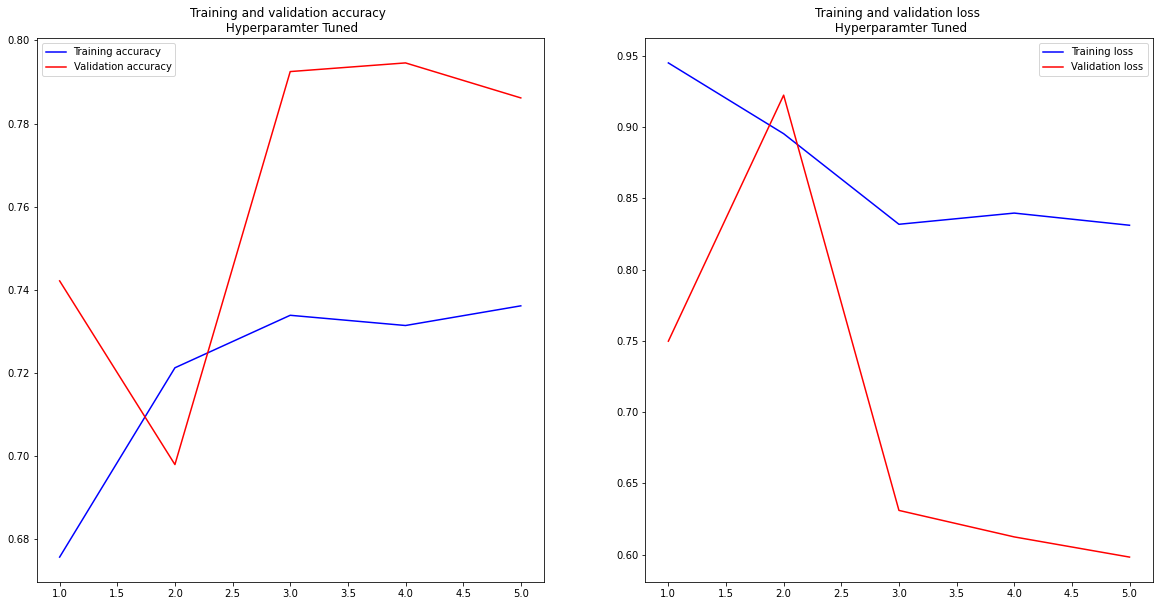

In [5]:
accuracy_1 = hypermodel_tuned.history["accuracy"]
val_accuracy_1 = hypermodel_tuned.history["val_accuracy"]
loss_1 = hypermodel_tuned.history["loss"]
val_loss_1 = hypermodel_tuned.history["val_loss"]
epochs_1 = range(1, len(accuracy_1) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_1, accuracy_1, "b", label="Training accuracy")
plt.plot(epochs_1, val_accuracy_1, "r", label="Validation accuracy")
plt.title("Training and validation accuracy \n Hyperparamter Tuned")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_1, loss_1, "b", label="Training loss")
plt.plot(epochs_1, val_loss_1, "r", label="Validation loss")
plt.title("Training and validation loss \n Hyperparamter Tuned")
plt.legend()
plt.show()

## Transfer learning 

For this part, I gonna choose a pre-trained network available in [keras.applications](https://keras.io/api/applications/). And Experiment with the pre-trained network.

In [11]:
#importing Requisite Libraries
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import os
import pandas as pd
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

#setting the directory path to variable dir
dir = 'C:/Users/Prithvi/Desktop/DAB300/Lab/Lab 4/Dataset' 

#DATASET LOADING AND PROCESSING WITH IMAGE DATA GENERATORS

#rescaling the trainig/test/ validation images, so that they are on the scale of 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)

#setting the batch size
batch_size=5

#Using train generators without augumentation

#Using flow from directory to augument data in batches.
train_generator = train_datagen.flow_from_directory(
    directory=r'C:/Users/Prithvi/Desktop/DAB300/Lab/Lab 4/Dataset/train', #giving the path to train data
    target_size=(148, 148), #resizing the images to 148,148
    color_mode="rgb", #setting the image as rgb
    classes=['flowers','not flower'], #giving the class names
    batch_size=batch_size, #setting the batch size, data will be augumented in the batch sizes
    shuffle=True, #shuffling the data, so that the model doesnt images of same class in a row and get biased
    seed=123 #setting the seed 
)


valid_generator = valid_datagen.flow_from_directory(
    directory=r'C:/Users/Prithvi/Desktop/DAB300/Lab/Lab 4/Dataset/validation',#giving the path to validation data
    target_size=(148, 148),#resizing the images to 148,148
    color_mode="rgb",#setting the image as rgb
    batch_size=batch_size,#setting the batch size, data will be augumented in the batch sizes
    classes=['flowers','not flower'],#giving the class names
    shuffle=True,#shuffling the data, so that the model doesnt images of same class in a row and get biased
    seed=123
)

test_generator = test_datagen.flow_from_directory(
    directory=r'C:/Users/Prithvi/Desktop/DAB300/Lab/Lab 4/Dataset/test',#giving the path to test data
    target_size=(148, 148),#resizing the images to 148,148
    color_mode="rgb",#setting the image as rgb
    classes=['flower', 'not flower'],#giving the class names
    batch_size=1,
    shuffle=False,
    seed=123
)

resnet= InceptionResNetV2(include_top=False,
                  weights="imagenet",input_shape=(148, 148, 3))

resnet.trainable = False

#Augumenting the data
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

#Instantiating an functional Pre trained Network
inputs = keras.Input(shape=(148, 148, 3))
x = data_augmentation(inputs)
x = tensorflow.keras.applications.inception_resnet_v2.preprocess_input(x)
x = resnet(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_TL = keras.Model(inputs, outputs)
model_TL.summary()

model_TL.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = keras.callbacks.ModelCheckpoint(filepath="Transfer_Learning.h5",
                                            save_best_only=True,
                                            monitor="val_loss",
                                           overwrite=True)


history = model_TL.fit(train_generator,
                    epochs=15,
                    validation_data=valid_generator,
                    callbacks=[callbacks])


Found 100 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 148, 148, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 148, 148, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 148, 148, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 148, 148, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
______

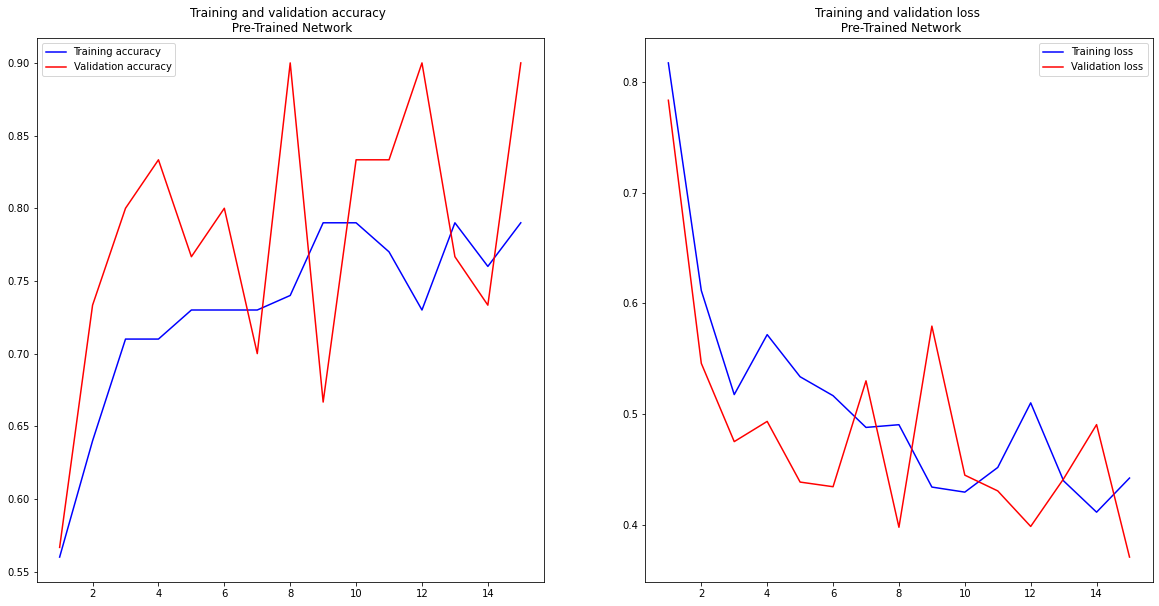

In [21]:
#Plotting accuracy and loss of pre-trained network:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy \n Pre-Trained Network")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss \n Pre-Trained Network")
plt.legend()
plt.show()

In [16]:
#Checking the Transfered learned model performance on test set
test_model = keras.models.load_model("Transfer_Learning.h5")
test_loss, test_acc = test_model.evaluate(test_generator)

print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 4s 51ms/step - loss: 0.4381 - accuracy: 0.7333
Test accuracy: 0.733


## Fine-tuning 


In [17]:
from tensorflow.keras import optimizers

#MAking all the layers trainable
resnet.trainable = True


for layer in resnet.layers[:-4]:
    layer.trainable=False
    
for layer in resnet.layers:
    print(f"Is layer {layer.name} trainable? {layer.trainable}")

    
resnet.summary()

model_TL.summary()

# That is the model we are fine-tuning

model_TL.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

callbacks = keras.callbacks.ModelCheckpoint(filepath="fine_tuning.h5",
                                            save_best_only=True,
                                            monitor="val_loss",
                                            overwrite=True)

#fitting the model
history_1= model_TL.fit(train_generator, epochs=15, validation_data=valid_generator,callbacks=[callbacks])

#Checking the fine tuned network on test set
model_TL_1 = keras.models.load_model("fine_tuning.h5")
test_loss, test_acc = model_TL_1.evaluate(test_generator)

#printing test accuracy
print(f"Test accuracy: {test_acc:.3f}")

Is layer input_1 trainable? False
Is layer conv2d_3 trainable? False
Is layer batch_normalization trainable? False
Is layer activation trainable? False
Is layer conv2d_4 trainable? False
Is layer batch_normalization_1 trainable? False
Is layer activation_1 trainable? False
Is layer conv2d_5 trainable? False
Is layer batch_normalization_2 trainable? False
Is layer activation_2 trainable? False
Is layer max_pooling2d_3 trainable? False
Is layer conv2d_6 trainable? False
Is layer batch_normalization_3 trainable? False
Is layer activation_3 trainable? False
Is layer conv2d_7 trainable? False
Is layer batch_normalization_4 trainable? False
Is layer activation_4 trainable? False
Is layer max_pooling2d_4 trainable? False
Is layer conv2d_11 trainable? False
Is layer batch_normalization_8 trainable? False
Is layer activation_8 trainable? False
Is layer conv2d_9 trainable? False
Is layer conv2d_12 trainable? False
Is layer batch_normalization_6 trainable? False
Is layer batch_normalization_9 tra

__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 3, 3, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 3, 3, 192)    576         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 3, 3, 192)    0           batch_normalization_164[0][0]    
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 3, 3, 224)    129024      activation_164[0][0]             
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, 3, 3, 224)    672         conv2d_168[0][0]                 
__________

20/20 [==============================] - 19s 412ms/step - loss: 1.1012 - accuracy: 0.8000 - val_loss: 0.4236 - val_accuracy: 0.8000
Epoch 2/15
20/20 [==============================] - 4s 220ms/step - loss: 1.0844 - accuracy: 0.7600 - val_loss: 0.4712 - val_accuracy: 0.8333
Epoch 3/15
20/20 [==============================] - 5s 235ms/step - loss: 0.7996 - accuracy: 0.8000 - val_loss: 0.4990 - val_accuracy: 0.8667
Epoch 4/15
20/20 [==============================] - 4s 225ms/step - loss: 1.1173 - accuracy: 0.7600 - val_loss: 0.5111 - val_accuracy: 0.8667
Epoch 5/15
20/20 [==============================] - 5s 271ms/step - loss: 1.0334 - accuracy: 0.8100 - val_loss: 0.5139 - val_accuracy: 0.8333
Epoch 6/15
20/20 [==============================] - 6s 303ms/step - loss: 0.8239 - accuracy: 0.7500 - val_loss: 0.5205 - val_accuracy: 0.8000
Epoch 7/15
20/20 [==============================] - 6s 284ms/step - loss: 0.7030 - accuracy: 0.7600 - val_loss: 0.5287 - val_accuracy: 0.8000
Epoch 8/15
20/20

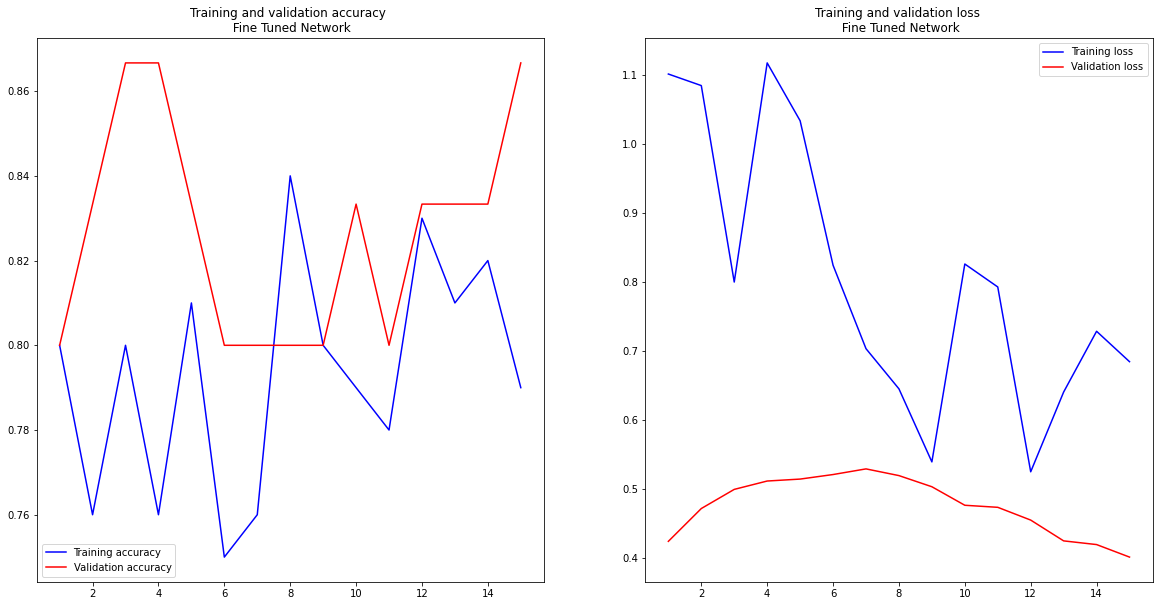

In [20]:
#Plotting accuracy and loss of Fine Tuned network:
accuracy_2 = history_1.history["accuracy"]
val_accuracy_2 = history_1.history["val_accuracy"]
loss_2 = history_1.history["loss"]
val_loss_2 = history_1.history["val_loss"]
epochs_2 = range(1, len(accuracy_2) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_2, accuracy_2, "b", label="Training accuracy")
plt.plot(epochs_2, val_accuracy_2, "r", label="Validation accuracy")
plt.title("Training and validation accuracy \n Fine Tuned Network")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_2, loss_2, "b", label="Training loss")
plt.plot(epochs_2, val_loss_2, "r", label="Validation loss")
plt.title("Training and validation loss \n Fine Tuned Network")
plt.legend()
plt.show()

# Summary

| Model | Validation Accuracy | Test Accuracy 
| :-: | :-: | :-: |
| Base Model | 87 | 90 |
| Model with data augumentation and pretained network | 90 | 73 |
| Fine_tunied model | 86 | 83 |